In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
sns.set_style('white')

In [2]:
# https://www.kaggle.com/c/titanic/data - датасет для анализа
data = pd.read_csv('train.csv') 

In [3]:
data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [4]:
np.round(100 * (data.Ticket.nunique() / data.PassengerId.nunique()))

76.0

In [5]:
np.round(100 * (data.Cabin.nunique() / data.PassengerId.nunique()))

16.0

####  Параметр "Ticket" может быть исключен исходя из нашего анализа, поскольку он не содержит полезной информации, в силу наличия большого количества дупликатов. Номером кабины (параметр "Cabin") также можно пренебречь, так как этот столбец не заполнен для значительного числа пассажиров (лишь для 16% пассажиров номер кабины известен). PassengerId не может быть исключен из набора данных, поскольку будет в дальнейшем использоваться для анализа. Name не может способствовать выживанию, но данный параметр необходим для определения титула. Что интересно, много данных отсутствует в таблице - для 177 пассажиров не указан возраст. Для кабин невозможно достоверно определить вероятность выживания, так как их анализ не предоставит достоверных результатов - 686 кабин не указаны в таблице

#### Уберем теперь два столбца "Cabin" и "Ticket".

In [6]:
data.drop(columns=['Cabin', 'Ticket'],axis=1, inplace = True)

#### Заменим буквенное обозначение названий портов на их полное название. 

In [7]:
data.loc[:,'Embarked'].replace(['C','S','Q'],['Cherbourg','Southampton','Queenstown'],inplace=True)

In [8]:
data.drop_duplicates().shape
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Southampton
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cherbourg
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Southampton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Southampton
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Southampton
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Southampton
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,Southampton
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,Southampton
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,Cherbourg


In [9]:
print('Количество пассажиров: ', data.PassengerId.nunique())
print('Общий процент выживших: {}%'.format(int(100 * data['Survived'].sum() / data.PassengerId.nunique())))

Количество пассажиров:  891
Общий процент выживших: 38%


#### Рассмотрим теперь зависимость от класса и возраста

#### Разберем более детально вопрос взаимосвязи возраста с выживанием с помощью гистограмм

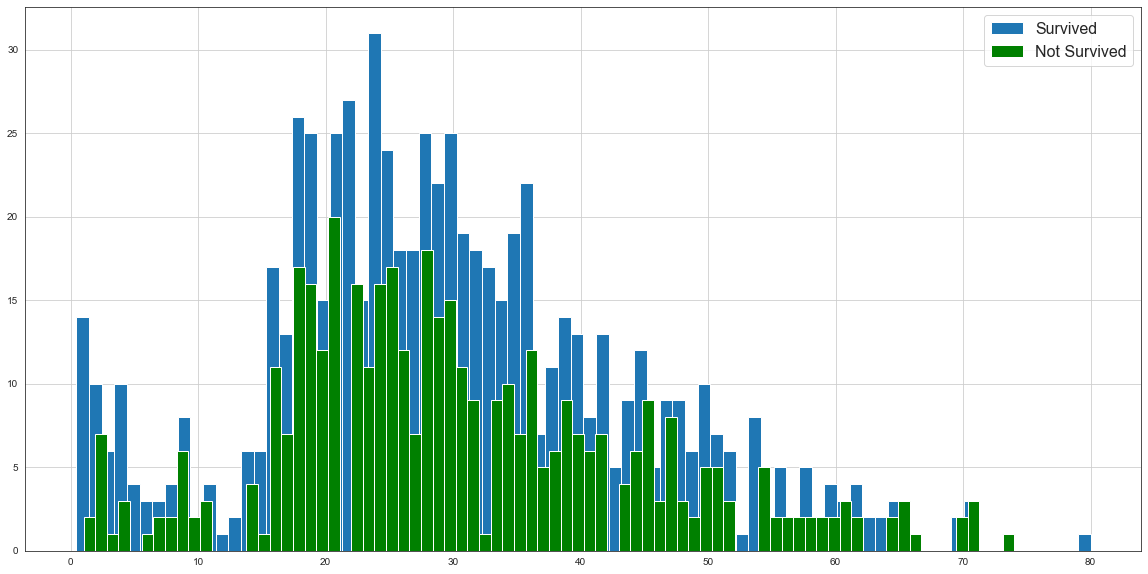

In [10]:
ax = data['Age'].hist(figsize=(20, 10), bins=80, edgecolor='white', grid=True)

data[data['Survived'] == 0]['Age'].hist(figsize=(20, 10), bins=80, 
                                          edgecolor='white', grid=True, color='green')
ax.legend(['Survived', 'Not Survived'], prop={'size':16})
plt.style.use("cyberpunk")

#### Исходя из результатов данной гистограммы сложно сказать, влиял ли в реальности возраст на выживаемость, необходимо разбить датафрейм, а в следствии и участников, на возрастные группы для более детального анализа.

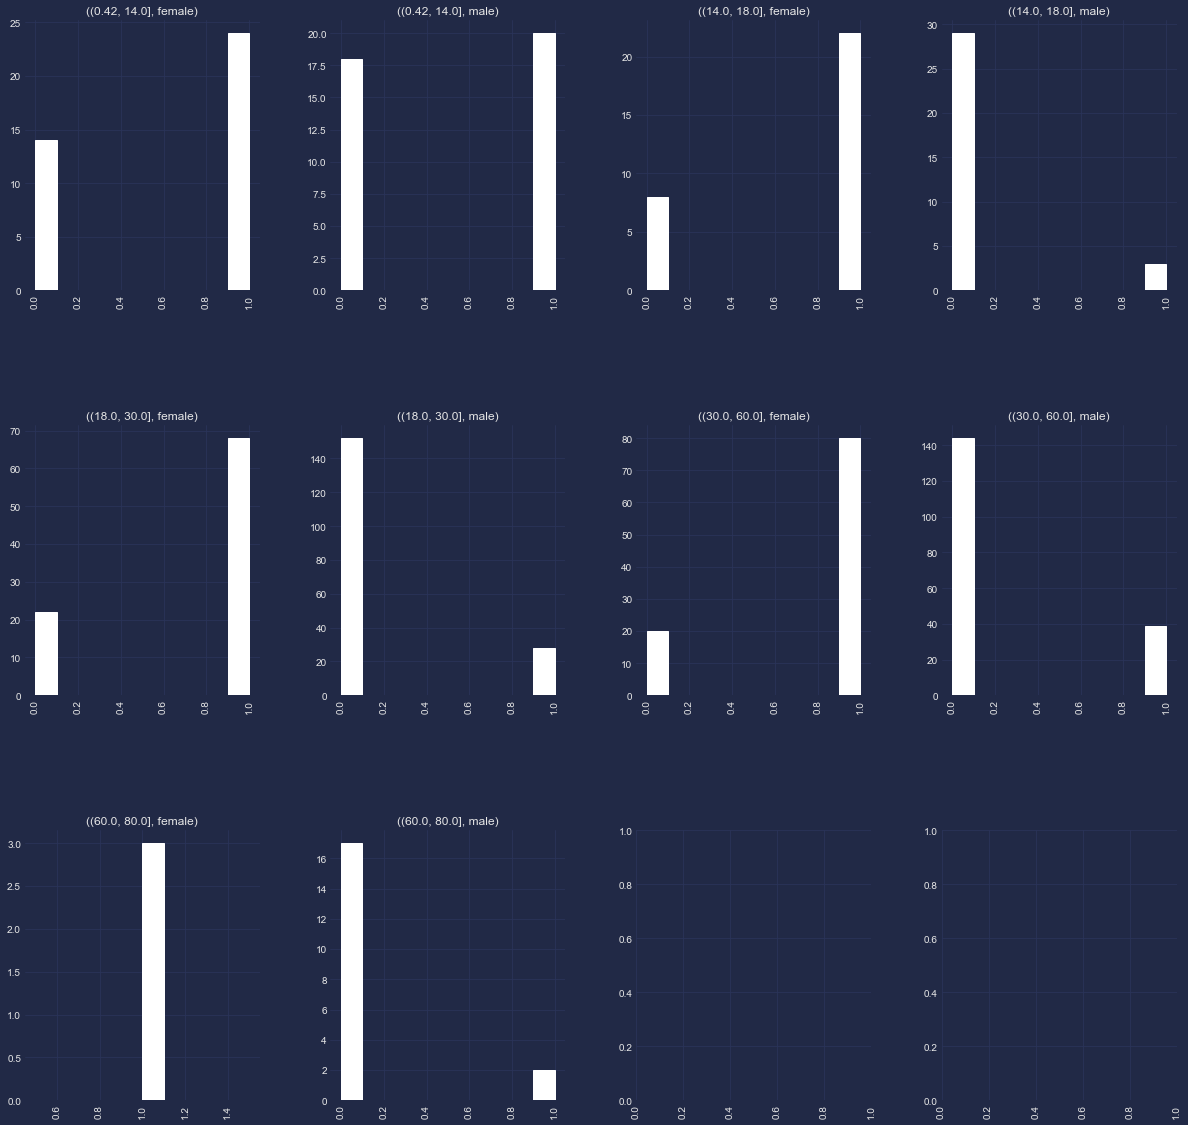

In [11]:
age_groups = [0.42,14,18,30,60,80]
data['age_group']=pd.cut(data['Age'],age_groups)
data[['age14','age18','age30','age60','age80']]=pd.get_dummies(data['age_group'])
data.hist("Survived", by=["age_group","Sex"], layout=[3,4], figsize = [20,20], color = 'white')
plt.style.use("cyberpunk")

In [12]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
age_group      178
age14            0
age18            0
age30            0
age60            0
age80            0
dtype: int64

#### Что интересно, много данных отсутствует в таблице - для 177 пассажиров не указан возраст. Для кабин невозможно достоверно определить вероятность выживания, так как их анализ не предоставит достоверных результатов - 686 кабин не указаны в таблице. Но для оставшихся данных можно сделать вывод, что набиольший шанс на выживание имели девушки и женщины - преимущественно молодые, что укладывается в канву истрический событий о том, кого первым спасали на Титанике - женщин и детей. 


#### Далее покажем на гистограмах количество выживших пассажиров в зависимости от количества родственников на борту.

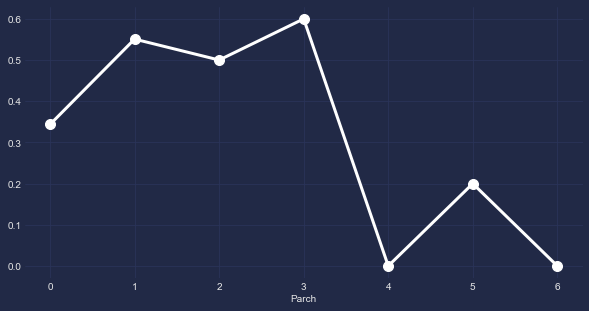

In [13]:
series = data.groupby(['Parch'])['Survived'].sum() / data.groupby(['Parch'])['Survived'].count()
series.plot(figsize=(10, 5), linestyle='-', marker='o', markersize=10, grid=True, lw=3, color = 'white')
plt.style.use("cyberpunk")

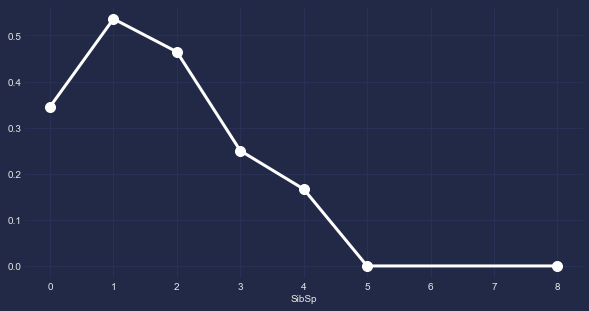

In [14]:
series = data.groupby(['SibSp'])['Survived'].sum() / data.groupby(['SibSp'])['Survived'].count()
series.plot(figsize=(10, 5), linestyle='-', marker='o', markersize=10, grid=True, lw=3, color = 'white')
plt.style.use("cyberpunk")

#### Из двух графиков выше получается, что есть некое оптимальное количество родственников на борту, можно, в целом, ввести понятие оптимального количества людей в группе и их шанс на выживание. При этом есть разница в шансе на выживание между количесвом родителей и детей на борту и количеством братьев, сестер и супругов. Наибольший шанс на выживание в первой группе (" Parch") имели пассажиры, у которых было три члена семьи, в данном случае родителя или ребенка на борту - шанс на выживание 60%, для второй же группы ("SibSp") - оптимальным количеством супругов или братьев/сестер - является 1. Шанс на выживание - выше 50%. 

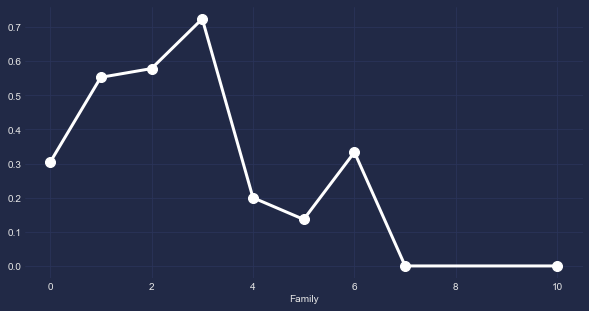

In [15]:
data['Family'] = data['SibSp'] + data['Parch']
series = data.groupby(['Family'])['Survived'].sum() / data.groupby(['Family'])['Survived'].count()
series.plot(figsize=(10, 5), linestyle='-', marker='o', markersize=10, grid=True, lw=3, color = 'white')
plt.style.use("cyberpunk")

####  Интересно, что данные о семье, то есть о количестве родственников на борту, показывает, что оптимально было иметь 1, 2, 3 членов семьи на борту для выживание - шанс выше 50%, для 3 - выше 70%.

#### Рассмотрим также более удобный способ представления наших данных в виде гистограммы, а также проведем более детальный анализ влияние порта, в котором человек сел на борт корабля и влияние класса на выживаниемость. 

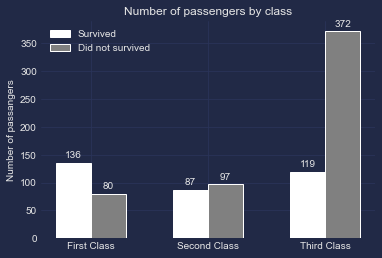

In [24]:
labels = ['First Class', 'Second Class', 'Third Class']
surv = (data[(data['Pclass'] == 1) & (data['Survived'] == 1)]['PassengerId'].count(),
             data[(data['Pclass'] == 2) & (data['Survived'] == 1)]['PassengerId'].count(),
              data[(data['Pclass'] == 3) & (data['Survived'] == 1)]['PassengerId'].count())
didntsurv = (data[(data['Pclass'] == 1) & (data['Survived'] == 0)]['PassengerId'].count(), 
              data[(data['Pclass'] == 2) & (data['Survived'] == 0)]['PassengerId'].count(),
               data[(data['Pclass'] == 3) & (data['Survived'] == 0)]['PassengerId'].count())


x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, surv, width, label='Survived', color='white')
rects2 = ax.bar(x + width/2, didntsurv, width, label='Did not survived',color='gray')
ax.set_ylabel('Number of passangers')
ax.set_title('Number of passengers by class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.style.use("cyberpunk")

#### Из данных гистограмм видно, что шанс на выживание в первом и во втором классе был куда выше, нежели в третьем.

In [17]:
data[['Embarked', 'Survived']].groupby(['Embarked']).mean().apply(lambda x: round(100 * x))

,Survived
Embarked,
Cherbourg,55.0
Queenstown,39.0
Southampton,34.0


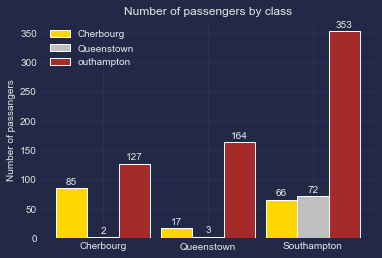

In [18]:
labels = ['Cherbourg', 'Queenstown', 'Southampton']

cherbourg = (data[(data['Pclass'] == 1) & (data['Embarked'] == 'Cherbourg')]['PassengerId'].count(), 
             data[(data['Pclass'] == 2) & (data['Embarked'] == 'Cherbourg')]['PassengerId'].count(), 
             data[(data['Pclass'] == 3) & (data['Embarked'] == 'Cherbourg')]['PassengerId'].count())
queenstown = (data[(data['Pclass'] == 1) & (data['Embarked'] == 'Queenstown')]['PassengerId'].count(), 
              data[(data['Pclass'] == 2) & (data['Embarked'] == 'Queenstown')]['PassengerId'].count(), 
              data[(data['Pclass'] == 3) & (data['Embarked'] == 'Queenstown')]['PassengerId'].count())
southampton = (data[(data['Pclass'] == 1) & (data['Embarked'] == 'Southampton')]['PassengerId'].count(), 
               data[(data['Pclass'] == 2) & (data['Embarked'] == 'Southampton')]['PassengerId'].count(), 
               data[(data['Pclass'] == 3) & (data['Embarked'] == 'Southampton')]['PassengerId'].count())

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, cherbourg, width, label='Cherbourg', color='white')
rects2 = ax.bar(x, queenstown, width, label='Queenstown',color='silver')
rects3 = ax.bar(x + width, southampton, width, label='outhampton',color='gray')
ax.set_ylabel('Number of passangers')
ax.set_title('Number of passengers by class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height-2),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.style.use("cyberpunk")

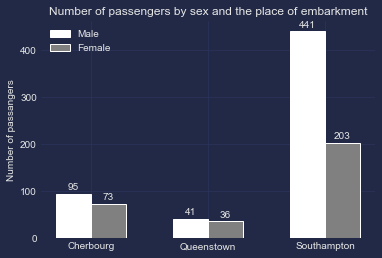

In [19]:
labels = ['Cherbourg', 'Queenstown', 'Southampton']

male = (data[(data['Sex'] == 'male') & (data['Embarked'] == 'Cherbourg')]['PassengerId'].count(),
        data[(data['Sex'] == 'male') & (data['Embarked'] == 'Queenstown')]['PassengerId'].count(),
        data[(data['Sex'] == 'male') & (data['Embarked'] == 'Southampton')]['PassengerId'].count())
        
female = (data[(data['Sex'] == 'female') & (data['Embarked'] == 'Cherbourg')]['PassengerId'].count(),
        data[(data['Sex'] == 'female') & (data['Embarked'] == 'Queenstown')]['PassengerId'].count(),
        data[(data['Sex'] == 'female') & (data['Embarked'] == 'Southampton')]['PassengerId'].count())

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Male', color='white')
rects2 = ax.bar(x + width/2, female, width, label='Female',color='gray')

ax.set_ylabel('Number of passangers')
ax.set_title('Number of passengers by sex and the place of embarkment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height-2),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.style.use("cyberpunk")

#### Получается, что нет зависимости выживаемости от порта, в котором человек зашел на борт, есть скорее зависимость от пола и класса. 

#### Один из параметров, который не упоминался нами ранее - титул, который был у человека, попробуем оценить, влиял ли он как-то на шанс выживания в катастрофе. 

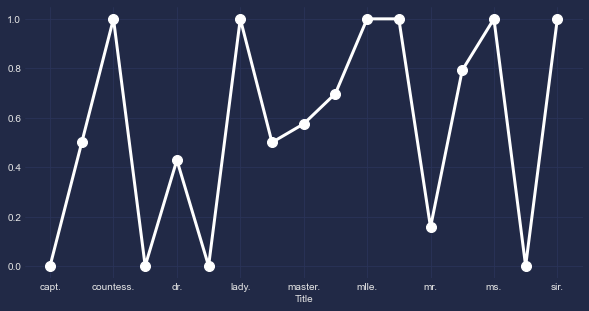

In [20]:
data['Title']=data['Name'].str.lower().str.extract('([a-z]*\.)', expand=True)
series = data.groupby(['Title'])['Survived'].sum() / data.groupby(['Title'])['Survived'].count()
series.plot(figsize=(10, 5), linestyle='-', marker='o', markersize=10, grid=True, lw=3, color = 'white')
plt.style.use("cyberpunk")

In [21]:
data.Title.replace({'mlle.':'mme.', 'miss.':'ms.'}, inplace=True)
data.Title.replace({'capt.':'mil. title', 'col.':'mil. title', 'major.':'mil. title'}, inplace=True)
data.groupby('Title').size()

Title
countess.       1
don.            1
dr.             7
jonkheer.       1
lady.           1
master.        40
mil. title      5
mme.            3
mr.           517
mrs.          125
ms.           183
rev.            6
sir.            1
dtype: int64

#### В данном случае сложно говорить о влиянии титула на шанс выживания в катастфрофе, так как количество людей с определенными титулами несоизмеримо мало, по отношению к общему количеству человек на борту, интерес, однако, представляют rev., dr., остальные же титулы могут быть отражены в выживаемости по полу. 

In [22]:
print('Общий процент выживших dr.: {} %'.format(int(100 * data[(data['Title'] == 'dr.')]['Survived'].sum() / data[(data['Title'] == 'dr.')].PassengerId.nunique())))
print('Общий процент выживших rev.: {} %'.format(int(100 * data[(data['Title'] == 'rev.')]['Survived'].sum() / data[(data['Title'] == 'rev.')].PassengerId.nunique())))

Общий процент выживших dr.: 42 %
Общий процент выживших rev.: 0 %


#### У докторов был довольно-таки высокий шанс на выживание - 42%. 

In [23]:
firstclass_fare_mean = data[(data['Pclass'] == 1)]['Fare'].mean()
secondclass_fare_mean = data[(data['Pclass'] == 2)]['Fare'].mean()
thirdclass_fare_mean = data[(data['Pclass'] == 3)]['Fare'].mean()

data['FareMoreThanMean'] = np.where(((data.Pclass == 1) & (data.Fare > firstclass_fare_mean)) |
    ((data.Pclass == 2) & (data.Fare > secondclass_fare_mean)) |
    ((data.Pclass == 3) & (data.Fare > thirdclass_fare_mean)), True, False)

judgingbyfare = data[['Pclass', 'FareMoreThanMean', 'Survived']].groupby(
    ['Pclass', 'FareMoreThanMean']).mean().apply(lambda x: round(100 * x))
judgingbyfare

Survived
Pclass FareMoreThanMean          
1      False                 57.0
       True                  77.0
2      False                 40.0
       True                  56.0
3      False                 23.0
       True                  27.0

#### Исходя из данных таблицы можно говорить о зависимости выживаемости от суммы, которую человек заплатил за билет: люди, заплатившие больше медианного значения имели больший шанс на выживание. 

#### Отсюда видно, что фактор выживания в катастрофе определенно связан с полом, класс же, в свою очередь, по этим данным не влияет на выживания, возможно, что он все же в связи с каким-то фактор, как пол, например, и возрастом, так девочки и девушки в первом и во втором классе имели весьма неплохие шансы на выживыание, стоит проверить - является ли этот результат достоверным, для этого стоит оценить количество людей каждого из этих классов. По наших данным, однако, очевидно, что возраст - фактор, влияющий на выживаемость, у детей опредленно шанс на выживание намного выше, чем у взрослых, вне зависимости от класса. Удивительно также, что количество выживших связано с портом, в котором человек зашел на борт корабля. Моя теория заключается в том, что это может быть связано с классом и возрастом, а также полом, для каждого порта необходимо будет проверить эти значения.  По итогу, можно утверждать, что выживаемость зависит от многих фактор, в большинстве своем работающих в связке с другими параметрами, как пол и возраст. 